In [2]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import os
import cv2 as cv

In [28]:
data_dir = "cancer_dataset"

In [29]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

In [30]:
os.listdir(data_dir)

['basal_cell_carcinoma',
 'melanoma',
 'not_cancerous',
 'squamous_cell_carcinoma']

In [31]:
for image_class in os.listdir(data_dir):
    print(image_class)

basal_cell_carcinoma
melanoma
not_cancerous
squamous_cell_carcinoma


In [32]:
# one_img_path = cv.imread(os.path.join(data_dir,'Blight', "Corn_Blight (1).jpg"))

In [33]:
# plt.imshow(one_img_path)

In [34]:
dataset = tf.keras.utils.image_dataset_from_directory("cancer_dataset")

Found 861 files belonging to 4 classes.


In [35]:
class_names = dataset.class_names
class_names

['basal_cell_carcinoma',
 'melanoma',
 'not_cancerous',
 'squamous_cell_carcinoma']

In [36]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[0 1 1 1 1 1 0 1 1 3 3 3 1 1 1 1 3 1 1 1 1 1 1 1 1 1 3 1 1 1 1 0]


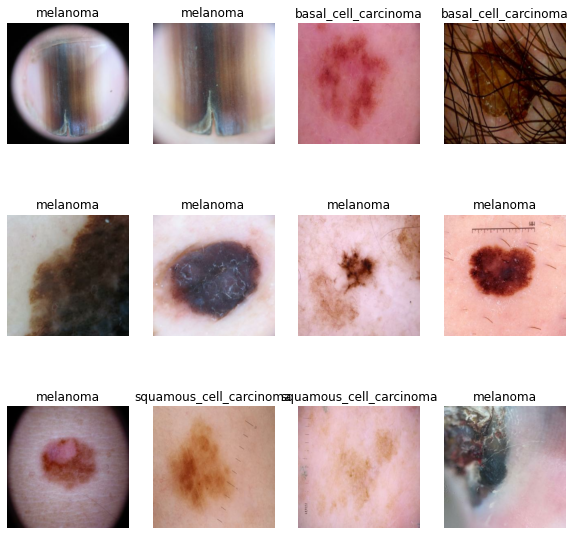

In [37]:
plt.figure(figsize = (10,10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4, i +1 )
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
#         plt.title(labels_batch[i].numpy())
        plt.axis("off")

In [38]:
len(dataset)

27

In [39]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [40]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [41]:
len(train_ds)

21

In [42]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [43]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [44]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [45]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [46]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 4

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [47]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d_6 (Conv2D)           (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPooling  (32, 127, 127, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (32, 60, 60, 64)         

In [48]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [49]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
21/21 [==============================] - 314s 15s/step - loss: 0.9747 - accuracy: 0.7055 - val_loss: 0.8780 - val_accuracy: 0.7344
Epoch 2/50
21/21 [==============================] - 321s 15s/step - loss: 0.8465 - accuracy: 0.7235 - val_loss: 0.8695 - val_accuracy: 0.7344
Epoch 3/50
21/21 [==============================] - 319s 15s/step - loss: 0.8121 - accuracy: 0.7235 - val_loss: 0.7233 - val_accuracy: 0.7344
Epoch 4/50
21/21 [==============================] - 319s 15s/step - loss: 0.7225 - accuracy: 0.7339 - val_loss: 0.6432 - val_accuracy: 0.7812
Epoch 5/50
21/21 [==============================] - 319s 15s/step - loss: 0.6382 - accuracy: 0.7683 - val_loss: 0.6293 - val_accuracy: 0.7812
Epoch 6/50
21/21 [==============================] - 322s 15s/step - loss: 0.5362 - accuracy: 0.7803 - val_loss: 0.5648 - val_accuracy: 0.7812
Epoch 7/50
21/21 [==============================] - 327s 16s/step - loss: 0.5165 - accuracy: 0.7967 - val_loss: 0.5405 - val_accuracy: 0.8125
Epoch 

In [50]:
scores = model.evaluate(test_ds)

4/4 [==============================] - 24s 5s/step - loss: 0.3118 - accuracy: 0.8960


In [51]:
scores

[0.31179749965667725, 0.8960000276565552]

In [52]:
history

In [53]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 21}

In [54]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [55]:
history.history['loss'][:5] 

[0.9747297167778015,
 0.8464741110801697,
 0.8120527863502502,
 0.7224984169006348,
 0.638163685798645]

In [56]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

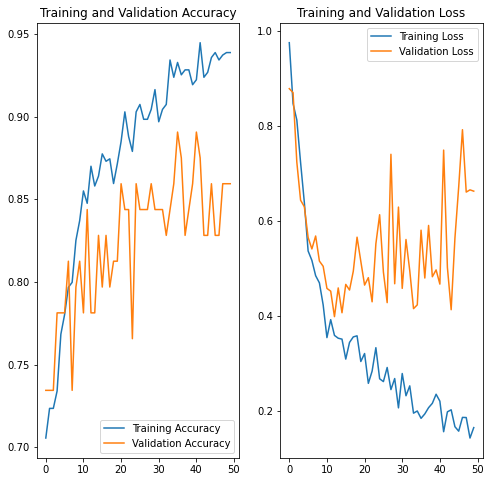

In [57]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: melanoma
1/1 [==============================] - 2s 2s/step
predicted label: melanoma


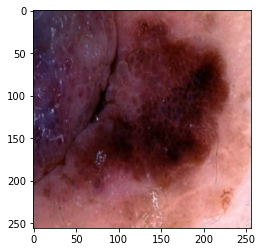

In [74]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [60]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 1s 516ms/step


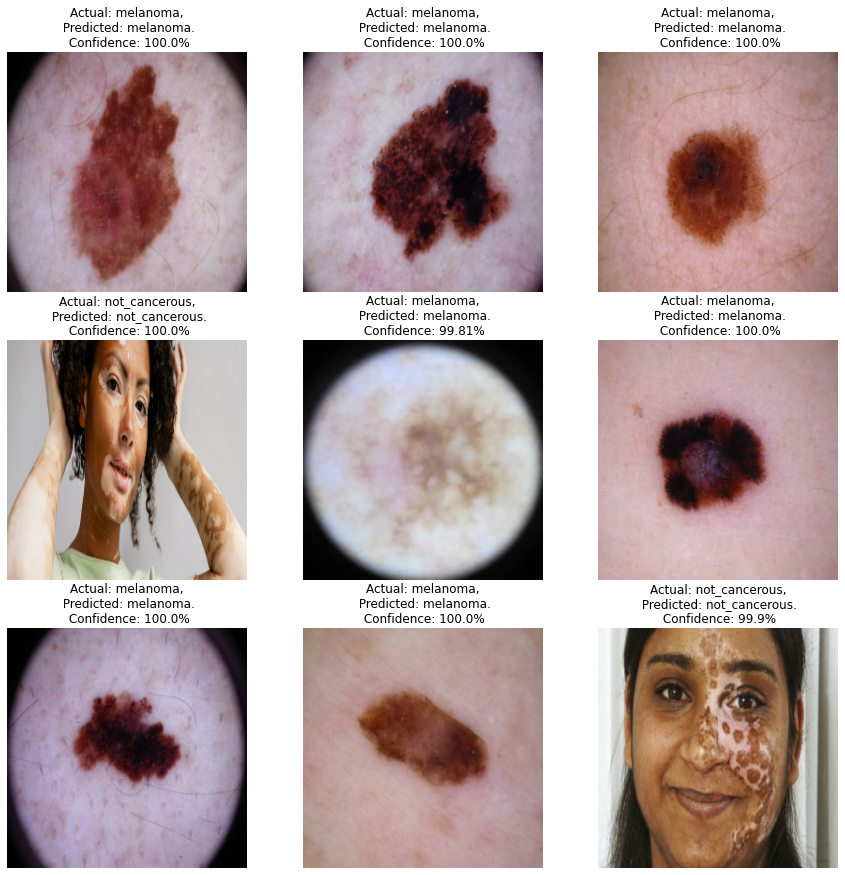

In [97]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [76]:
import os
model_version=max([int(i) for i in os.listdir("models") + [0]])+1
model.save(f"models/{model_version}")

INFO:tensorflow:Assets written to: models/1\assets


INFO:tensorflow:Assets written to: models/1\assets


In [77]:
model.save("cancer.h5")

In [78]:
import cv2

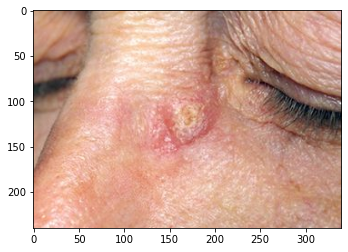

In [80]:
img = cv2.imread('EyeArticle_3-340x240.jpg')
# plt.imshow(img)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

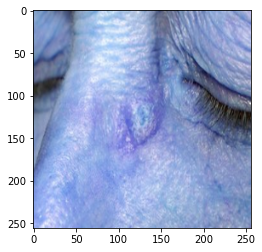

In [81]:
resize = tf.image.resize(img, (256,256))
# resize = tf.image.resize(img)

plt.imshow(resize.numpy().astype(int))
plt.show()

In [82]:
np.expand_dims(resize, 0).shape

(1, 256, 256, 3)

In [83]:
np.argmax(array([[8.9812957e-16, 1.0000000e+00, 2.7374273e-16, 4.5284643e-24]]))

NameError: name 'array' is not defined

In [84]:
from keras import models
from keras.models import load_model

In [85]:
reload_model = load_model(os.path.join('models', "cancer.h5"))

In [86]:
reload_model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 364ms/step


array([[3.1790578e-01, 5.9768391e-01, 8.4409170e-02, 1.2167044e-06]],
      dtype=float32)

In [87]:
class_names

['basal_cell_carcinoma',
 'melanoma',
 'not_cancerous',
 'squamous_cell_carcinoma']

In [145]:
# reload_model.predict("PLNTPTH-CER-02_Figure_1.jpg")
reload_model.predict(np.expand_dims("PLNTPTH-CER-02_Figure_1.jpg"/255, 0))

TypeError: unsupported operand type(s) for /: 'str' and 'int'

first image to predict
actual label: melanoma
1/1 [==============================] - 2s 2s/step
predicted label: melanoma


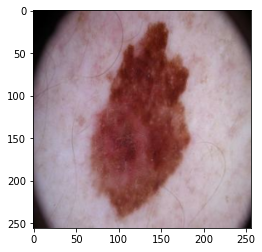

In [88]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [89]:
datasets = tf.keras.utils.image_dataset_from_directory("testing")

Found 450 files belonging to 1 classes.


first image to predict
1/1 [==============================] - 2s 2s/step
predicted label: squamous_cell_carcinoma


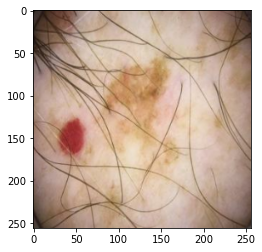

In [96]:
import numpy as np
for images_batch, labels_batch in datasets.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
#     print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])